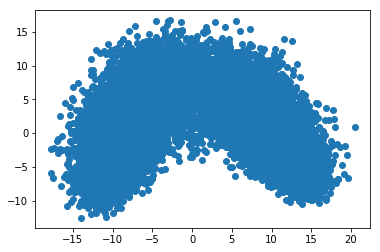

/Users/zhanghongwei/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Epoch: 0 [0/20000 (0%)]	Loss: 0.700468
Train Epoch: 0 [5000/20000 (25%)]	Loss: 0.784853
Train Epoch: 0 [10000/20000 (50%)]	Loss: 0.364276
Train Epoch: 0 [15000/20000 (75%)]	Loss: 0.201013
Train Epoch: 1 [0/20000 (0%)]	Loss: 0.187159
Train Epoch: 1 [5000/20000 (25%)]	Loss: 0.145561
Train Epoch: 1 [10000/20000 (50%)]	Loss: 0.194086
Train Epoch: 1 [15000/20000 (75%)]	Loss: 0.221807
Train Epoch: 2 [0/20000 (0%)]	Loss: 0.275048
Train Epoch: 2 [5000/20000 (25%)]	Loss: 0.360404
Train Epoch: 2 [10000/20000 (50%)]	Loss: 0.577776
Train Epoch: 2 [15000/20000 (75%)]	Loss: 0.310794
Train Epoch: 3 [0/20000 (0%)]	Loss: 0.633183
Train Epoch: 3 [5000/20000 (25%)]	Loss: 0.731298
Train Epoch: 3 [10000/20000 (50%)]	Loss: 0.180218
Train Epoch: 3 [15000/20000 (75%)]	Loss: 0.173322
Train Epoch: 4 [0/20000 (0%)]	Loss: 0.790935
Train Epoch: 4 [5000/20000 (25%)]	Loss: 0.312364
Train Epoch: 4 [10000/20000 (50%)]	Loss: 0.152492
Train Epoch: 4 [15000/20000 (75%)]	Loss: 0.166355
Train Epoch: 5 [0/20000 (0%)]	

/Users/zhanghongwei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:

import h5py
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from torchvision.datasets import ImageFolder

np.random.seed(2020)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
batch_size = 100             # 每次训练的批量
hidden_units = 5120          # 全连接层隐藏单元数
num_labels = 2               # 输出类别数
dropout_rate = 0.5           # Dropout概率
learning_rate = 0.1          # 初始学习率
learning_rate_decay = 1      # 学习率衰减系数
lr_decat_step = 400          # 学习率衰减轮数
weight_decay = 5e-4          # 正则化系数
momentum = 0.9               # 动量系数
epochs = 8                   # 训练轮数
verbose = False              # 显示训练过程
train_from_scratch = True    # 是否从头开始训练

# 配置 GPU/CPU 设备
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 读取特征数据
def read_data():
    X_train = []
    X_pred = []
    
    for filename in ["googlenet.h5", "resnet50.h5", "resnext.h5"]:
        with h5py.File(filename, 'r') as h:
            X_train.append(np.array(h['train']))
            X_pred.append(np.array(h['test']))
            y_train = np.array(h['label'])
    
    X_train = np.concatenate(X_train, axis = 1)
    X_pred = np.concatenate(X_pred, axis = 1)
    assert X_train.shape == (25000, hidden_units)
    assert X_pred.shape == (12500, hidden_units)
    
    X_train, y_train = shuffle(X_train, y_train)
    return X_train, y_train, X_pred

# 构建网络结构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(hidden_units, num_labels)

    def forward(self, x):
        x = self.fc(x)
        x = F.dropout(x, dropout_rate, training = self.training)
        return x

# 配置模型，是否继续上一次的训练
model = Net()
if train_from_scratch == False:
    model.load_state_dict(torch.load('model.pth'))
model.to(device)

# 设置优化器
optimizer = optim.SGD(model.parameters(), lr = learning_rate,
                      momentum = momentum, weight_decay=weight_decay)

# 设置学习率衰减
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = lr_decat_step,
                                      gamma = learning_rate_decay)

# 设置损失函数
loss_func = nn.CrossEntropyLoss()

# 定义训练过程
def train(train_loader, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        scheduler.step()
        loss = loss_func(output, target)

        if batch_idx % 50 == 0 & verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  

# 定义测试过程
def test(test_loader):
    test_loss = 0.
    correct = 0.
    model.eval()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
                test_loss.item(), correct, len(test_loader.dataset),
                100. * correct.type(torch.float) / len(test_loader.dataset)))

# 定义预测过程
def predict(X_pred):
    model.eval()
    
    with torch.no_grad():
        X_pred = X_pred.to(device)
        output = model(X_pred)
    
    output = output.argmax(dim = 1).cpu()
    y_pred = output.numpy().clip(0.01, 0.99)
    
    dataset = ImageFolder('data/test')
    df = pd.read_csv("sample_submission.csv")

    for i in range(len(y_pred)):
        fname = dataset.imgs[i][0]
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        df.label[index-1] = y_pred[i]
        
    df.to_csv('pred.csv', index = None)
    
    
if __name__ == '__main__':
    X_train, y_train, X_pred = read_data()
    
    # 数据可视化
    pca = PCA(n_components=2)
    newX = pca.fit_transform(X_train)
    plt.scatter(newX[:,0], newX[:,1])
    plt.show()
    
    X_train = torch.from_numpy(X_train).type(torch.float)
    y_train = torch.from_numpy(y_train).type(torch.long)
    X_pred = torch.from_numpy(X_pred).type(torch.float)
    
    train_dataset = torch.utils.data.TensorDataset(X_train[5000:], y_train[5000:])
    
    test_dataset = torch.utils.data.TensorDataset(X_train[0:5000], y_train[0:5000])
    
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               num_workers = 2)
    
    test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                              batch_size = batch_size,
                                              shuffle = True)
    
    for epoch in range(epochs):
        train(train_loader, epoch)
    test(test_loader)
    torch.save(model.state_dict(), 'model.pth')
    predict(X_pred)